---

## Project Purpose    
 
This  project aims to analyze tweets from @RutgersU and former President Donald Trump to explore how online media transforms communication. Trump's tweets highlight the influence of social media on public discourse, often shaping traditional media coverage, and posts from prominent figures like Trump and Elon Musk can move markets and spark widespread debate.

The project invites an objective analysis of the emotions, controversies, and nuances in Trump's tweets, offering a unique perspective on his use of Twitter. This analysis is unbiased and focused solely on data-driven insights, emphasizing the importance of impartiality in data science.

## Set up Libraries


In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import json

pd.set_option('max_colwidth', 280)

%matplotlib inline
%pip install seaborn
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set()
sns.set_context("talk")
import re


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Rutgers Twitter Data Analysis

In [2]:
from pathlib import Path
import json

ds_tweets_save_path = "RutgersU_recent_tweets.json"   

# Stopping attempts to download the data multiple times:
if not Path(ds_tweets_save_path).is_file():
    # Saving the tweets to a json file
    with open(ds_tweets_save_path, "w") as f:        
        json.dump(rutgers_tweets, f)

# Re-loading the json file:
with open(ds_tweets_save_path, "r") as f:
    rutgers_tweets = json.load(f)

### Print the first tweet 

In [3]:
from pprint import pprint # ...to get a more easily-readable view.
pprint(rutgers_tweets[0])

{'contributors': None,
 'coordinates': None,
 'created_at': 'Sat Nov 02 23:02:49 +0000 2019',
 'display_text_range': [0, 140],
 'entities': {'hashtags': [{'indices': [22, 31], 'text': 'internet'}],
              'symbols': [],
              'urls': [],
              'user_mentions': [{'id': 955836661702774784,
                                 'id_str': '955836661702774784',
                                 'indices': [3, 13],
                                 'name': 'Rutgers University–New Brunswick',
                                 'screen_name': 'RutgersNB'},
                                {'id': 52517689,
                                 'id_str': '52517689',
                                 'indices': [42, 58],
                                 'name': 'Rutgers School of Communication and '
                                         'Information',
                                 'screen_name': 'RutgersCommInfo'},
                                {'id': 392737670,
                   

### Create a list of Tweets and Print the first 50 Tweets

In [4]:
def display_tweets(tweets_data, num_tweets=50):
    tweets_list = []
    for tweet in tweets_data:
        if 'full_text' in tweet:
            tweet_text = tweet['full_text']
        elif 'text' in tweet:
            tweet_text = tweet['text']
        else:
            continue
        #remove RT
        if tweet_text.startswith('RT @'):
            colon_index = tweet_text.find(': ')
            if colon_index != -1:
                tweet_text = tweet_text[colon_index + 2:]
        #remove @
        tweet_text = re.sub(r'@\w+', '', tweet_text)
        tweet_text = re.sub(r'\(\s*\)', '', tweet_text)
        tweet_text = re.sub(r'\s+', ' ', tweet_text).strip()
        
        tweets_list.append(tweet_text)

    for i, tweet in enumerate(tweets_list[:num_tweets], 1):
        print(f"\n {i}:")
        print(tweet)
    
    return tweets_list

tweets_list = display_tweets(rutgers_tweets, 50)


 1:
As the #internet turns 50, 's focuses on how we have used the innovation and what it has meant f…

 2:
According to U.S. Rep. , "continuous pharmaceutical manufacturing is the future of medicine." Now, new legislat…

 3:
The 34th Annual Mary Philbrook Public Interest Award Celebration honored Lloyd Freeman RLAW'07 , Partner and…

 4:
We will be holding our 4th Annual MLK Oratorical Competition in January 2020. You must write &amp; recite an original speech c…

 5:
Happy first day of November! Can you believe we are already more than halfway through the semester? 🍂 📷: on Instagram https://t.co/8tOBOjvVzl

 6:
To learn more about 's new pharmaceutical manufactu…

 7:
Daniel Hayden went back to school to pursue a physics degree and found a new home in the where he was able to deepen his love of music by building his own guitar. Read his story: https://t.co/sQGqQsLBjZ #RutgersImpact

 8:
Discussing politics – especially with someone who doesn’t agree with you – can be challenging. But

### Print Time Range of Tweets

In [5]:
from datetime import datetime
def time_range(tweets_data):
    
    tweet_dates = [datetime.strptime(tweet['created_at'], "%a %b %d %H:%M:%S %z %Y") for tweet in tweets_data]
    
    min_date = min(tweet_dates)
    max_date = max(tweet_dates)
    
    earliest_date = min_date.strftime("%a %b %d %Y")
    latest_date = max_date.strftime("%a %b %d %Y")
    
    print(f"Time Range:{earliest_date} to {latest_date}")

time_range(rutgers_tweets)

Time Range:Fri Oct 19 2018 to Sat Nov 02 2019


### Print Top 10 Handles Tweeted by RutgersU Using Regex

In [6]:
import re
from collections import Counter

def top_handles(tweets_data, top_n=10):
    handles = []
    for tweet in tweets_data:
        handles.extend(re.findall(r"@\w+", tweet.get('full_text', '')))
    
    handle_counts = Counter(handles)
    top_handles = handle_counts.most_common(top_n)
    for handle, count in top_handles:
        print(f"{handle}: {count}")
    
top_handles(rutgers_tweets, 10)

@Rutgers_Camden: 272
@RutgersU: 231
@RutgersNB: 190
@RutgersU_News: 179
@RutgersLaw: 172
@Rutgers_Newark: 171
@RFootball: 163
@RUAthletics: 156
@rutgersalumni: 126
@MasonGross: 116


### Using SentenceTransformer for Text Embedding

In [7]:
%pip install --upgrade sentence-transformers


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Computing Cosine Similarity Matrix
 The code calculates the cosine similarity between all tweet pairs, producing a similarity matrix using a pre-trained BERT-based model from the SentenceTransformer library to encode tweets into dense vector representations. A 10x10 subset of this matrix, which displays the similarity scores for the first 10 tweets, is printed for analysis.

In [8]:
from sentence_transformers import SentenceTransformer, util
import numpy as np

# Load bert model
model = SentenceTransformer('all-MiniLM-L6-v2')

# first ten tweets
firstTweets= tweets_list[:10]

#Convert tweets to vectors
tweetVectors = model.encode(firstTweets, convert_to_tensor=True)

#calculate the cosine similarity for every pair of tweets in the first ten
cosSimilarity= util.pytorch_cos_sim(tweetVectors, tweetVectors)

#convert the cosine similarities to a matrix and output 
similarities = cosSimilarity.numpy()
print("Columns 1-7:")
print(np.round(similarities[:, :7], 6))
print("Columns 8-10:")
print(np.round(similarities[:, 7:], 6))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Columns 1-7:
[[ 1.        0.321464  0.060753  0.243417  0.108562  0.314758  0.122139]
 [ 0.321464  1.        0.018486  0.1926    0.105374  0.611384  0.044425]
 [ 0.060753  0.018486  1.        0.256089  0.133944 -0.013188  0.076565]
 [ 0.243417  0.1926    0.256089  1.        0.2478    0.158416  0.034603]
 [ 0.108562  0.105374  0.133944  0.2478    1.        0.121219  0.084588]
 [ 0.314758  0.611384 -0.013188  0.158416  0.121219  1.        0.093057]
 [ 0.122139  0.044425  0.076565  0.034603  0.084588  0.093057  1.      ]
 [ 0.093312  0.029063  0.013347  0.280811  0.066708 -0.009171 -0.053009]
 [ 0.215061  0.177833  0.165775  0.352341  0.333768  0.259392  0.076819]
 [ 0.105357  0.103784  0.136824  0.2282    0.303332  0.087716  0.023971]]
Columns 8-10:
[[ 0.093312  0.215061  0.105357]
 [ 0.029063  0.177833  0.103784]
 [ 0.013347  0.165775  0.136824]
 [ 0.280811  0.352341  0.2282  ]
 [ 0.066708  0.333768  0.303332]
 [-0.009171  0.259392  0.087716]
 [-0.053009  0.076819  0.023971]
 [ 1.      

### Finding Closest Tweets
closest_tweets(tweets_list, n, m) takes a list of tweets, selects n random tweets, and identifies the m closest tweets to each selected tweet based on their similarity. It returns a dictionary where each key is the ID of a random tweet, and the value is a list of m closest tweet IDs.

In [9]:
from sentence_transformers import SentenceTransformer, util
import numpy as np
import random

def closest_tweets(tweets, n, m):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    #calculate random tweet indices from tweets
    tweetAmount = len(tweets)
    randTweets = random.sample(range(tweetAmount), n)
    #get the text in each tweet if the text is not null
    randTweetsTexts = [tweet['full_text'] for tweet in tweets]
    # Convert all text tweets to numerical vectors representing thos tweets
    tweetVectors = model.encode(randTweetsTexts, convert_to_tensor=True)
    #dictionary to hold results
    closestTweets = {}
   
    for index in randTweets:
        #extract the vector representing the tweet
        currentTweet = tweetVectors[index]
        #get cosine similarity calculation with all other tweets and convert to numpy array
        cosSimScore = util.pytorch_cos_sim(currentTweet, tweetVectors)[0]
        cosSimScore = cosSimScore.numpy()
        #get the indices of the most similar tweets, this will include itself
        mostSimilarTweets = np.argsort(cosSimScore)[::-1][:m+1]
        #get rid of the tweet that is equal to itself, as it's not informative in our answer
        mostSimilarTweets = mostSimilarTweets[mostSimilarTweets != index][:m]
        #get the id of the current tweet
        currentTweetId = tweets[index]['id']
        #get the id's of the most similar tweets contained in top_indices
        mostSimilarIds = [tweets[i]['id'] for i in mostSimilarTweets]
        #store the most similar tweets in the dictionary and return
        closestTweets[currentTweetId] = mostSimilarIds
    return closestTweets



#### Testing closest_tweets()

In [10]:
closest_tweets(rutgers_tweets, 10, 5)

{1067460580666150912: [1166742394500460549,
  1176117951860269057,
  1158400298668515330,
  1073226071275958272,
  1107617116486815744],
 1072543463105814528: [1075039371391324162,
  1072890557289115648,
  1073599781002465280,
  1073617944066879488,
  1072541207023243264],
 1137434230949056512: [1064618876061868032,
  1170018339743260673,
  1170529421905846272,
  1056703874021625856,
  1103470920352649216],
 1113196931369582592: [1112802837585686528,
  1180190862346723334,
  1100039080308559872,
  1111652833726812161,
  1072541396744187905],
 1126183499835297792: [1082305935404687360,
  1105513937422958594,
  1083007050404298752,
  1159903514245685251,
  1180129796015230976],
 1059526392600322048: [1098818689460330496,
  1098559244058746881,
  1112802856887881728,
  1156975767114461186,
  1105061239024164865],
 1111653009191256066: [1111622678283210752,
  1073251999460806657,
  1106646267634036738,
  1160192857510219776,
  1062793093085315072],
 1113858458825166849: [110414833453569229

### Printing Clusters of Similar Tweets
Prints 3 random tweets and the 5 tweets that are closest to it based on cosine similary matrix. 

In [11]:
similarTweets = closest_tweets(rutgers_tweets,3, 5)

#dictionary for accessing texts of tweets from tweet id's, only includes tweets that are not null
tweetDictionary = {tweet['id']: tweet['full_text'] for tweet in rutgers_tweets}


for originalTweetId, similarTweetIds in similarTweets.items():
    print(f"\nOriginal Tweet:")
    print(f"{tweetDictionary[originalTweetId]}")
    print("\nClosest Tweets:")
    
    for similarityRank, simId in enumerate(similarTweetIds, 1):
        print(f"{similarityRank}. {tweetDictionary[simId]}")
 


Original Tweet:
RT @RutgersBHS: The deadline to showcase your artistic talents as part of @Rutgers_NJMS 8th Annual National Arts Program Exhibit is approac…

Closest Tweets:
1. RT @RutgersBHS: The #Rutgers University @NationalArts Program is gearing up for its 8th exhibit, starting on January 21st at @NJMSDeansOffi…
2. RT @Rutgers_Camden: 📣 Calling all artists: @CityofCamdenGov, @coopersferry, &amp; @RutgersArts want to hear from you! We welcome proposals from…
3. RT @rucfinearts: Calling all NJ high school artists!! The Student Works Gallery is accepting submissions for our student exhibit New Vision…
4. RT @RutgersNB: Between January 21st and February 28th, the work of artist facilitators who paired with over 30 area non-profit organization…
5. Meet Brooke Kamin Rapaport, a #Rutgers alumna using her roles as deputy director and senior curator of @MadSqParkNYC and commissioner of the United States Pavilion at this year’s @la_Biennale to change the way we think about public art. #Rutg

## Trump Twitter Data Analysis

In [12]:
def load_tweets(path):
    """Loads tweets that have previously been saved.
    Returns:
        list: A list of Dictionary objects, each representing one tweet."""
    
    with open(path, "rb") as f:
        import json
        return json.load(f)

#### Load realdonaldtrump_tweets_1.json

In [13]:
dest_path = "realdonaldtrump_tweets_1.json"
trump_tweets = load_tweets(dest_path)


#### Print the earliest 10 tweets in the dataset

In [14]:
# print the earliest 10 Trump tweets
import pandas as pd
from datetime import datetime

df = pd.DataFrame(trump_tweets)

df['created_at'] = pd.to_datetime(df['created_at'], format='%a %b %d %H:%M:%S %z %Y')

df = df.sort_values('created_at', ascending=True)
df.head(10)

,created_at,id,id_str,full_text,truncated,display_text_range,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,...,quoted_status_permalink,quoted_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,extended_entities,retweeted_status
3213,2017-10-19 11:56:15+00:00,920981920787386368,920981920787386368,"Workers of firm involved with the discredited and Fake Dossier take the 5th. Who paid for it, Russia, the FBI or the Dems (or all)?",False,"[0, 131]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': []}","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,None,...,NaN,NaN,24788,83417,False,False,NaN,en,NaN,NaN
3212,2017-10-19 12:21:18+00:00,920988223362469891,920988223362469891,".@foxandfriends ""Russia sent millions to Clinton Foundation""",False,"[0, 60]","{'hashtags': [], 'symbols': [], 'user_mentions': [{'screen_name': 'foxandfriends', 'name': 'FOX & friends', 'id': 15513604, 'id_str': '15513604', 'indices': [1, 15]}], 'urls': []}","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,None,...,NaN,NaN,23219,69861,False,False,NaN,en,NaN,NaN
3211,2017-10-19 20:40:21+00:00,921113816053755904,921113816053755904,It was great to have Governor @RicardoRossello of #PuertoRico🇵🇷with us at the @WhiteHouse today. We are with you! #PRStrong https://t.co/Op2xDZxvNc,False,"[0, 123]","{'hashtags': [{'text': 'PuertoRico', 'indices': [50, 61]}, {'text': 'PRStrong', 'indices': [114, 123]}], 'symbols': [], 'user_mentions': [{'screen_name': 'ricardorossello', 'name': 'Ricardo Rossello', 'id': 80013913, 'id_str': '80013913', 'indices': [30, 46]}, {'screen_name':...","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,None,...,NaN,NaN,10158,47493,False,False,False,en,"{'media': [{'id': 921113597752807431, 'id_str': '921113597752807431', 'indices': [124, 147], 'media_url': 'http://pbs.twimg.com/ext_tw_video_thumb/921113597752807431/pu/img/QO4Yk0jtqndc4snd.jpg', 'media_url_https': 'https://pbs.twimg.com/ext_tw_video_thumb/921113597752807431/...",NaN
3210,2017-10-20 01:43:00+00:00,921189980843663360,921189980843663360,"Keep up the GREAT work. I am with you 100%!\n\n""ISIS is losing its grip...""\nArmy Colonel Ryan Dillon\nCJTF–OIR\nhttps://t.co/jVGuvv5mzm https://t.co/PSCXg38CtS",False,"[0, 131]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/jVGuvv5mzm', 'expanded_url': 'http://45.wh.gov/OIR', 'display_url': '45.wh.gov/OIR', 'indices': [108, 131]}], 'media': [{'id': 921178032366288897, 'id_str': '921178032366288897', 'indices': [1...","<a href=""https://studio.twitter.com"" rel=""nofollow"">Media Studio</a>",NaN,None,...,NaN,NaN,11882,52196,False,False,False,en,"{'media': [{'id': 921178032366288897, 'id_str': '921178032366288897', 'indices': [132, 155], 'media_url': 'http://pbs.twimg.com/media/DMizJLXW0AE6O2l.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DMizJLXW0AE6O2l.jpg', 'url': 'https://t.co/PSCXg38CtS', 'display_url': '...",NaN
3209,2017-10-20 02:53:42+00:00,921207772233990144,921207772233990144,"The Fake News is going crazy with wacky Congresswoman Wilson(D), who was SECRETLY on a very personal call, and gave a total lie on content!",False,"[0, 139]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': []}","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,None,...,NaN,NaN,19277,85920,False,False,NaN,en,NaN,NaN
3208,2017-10-20 03:00:42+00:00,921209530628956161,921209530628956161,Big ratings getter @seanhannity and Apprentice Champion John Rich are right now going on stage in Las Vegas for #VegasStrong. Great Show!,False,"[0, 137]","{'hashtags': [{'text': 'VegasStrong', 'indices': [112, 124]}], 'symbols': [], 'user_mentions': [{'screen_name': 'seanhannity', 'name': 'Sean Hannity', 'id': 41634520, 'id_str': '41634520', 'indices': [19, 31]}], 'urls': []}","<a href=""http://twi

### Find Month of Oldest Tweet

In [15]:
def oldest_tweet(df):
    import pandas as pd

    from datetime import datetime

    df = pd.DataFrame(df)

    df['time'] = pd.to_datetime(df['created_at'], format='%a %b %d %H:%M:%S %z %Y')

    oldestTweet = df['time'].min()
    
    oldestMonth = oldestTweet.month
    
    return oldestMonth

oldest_month = oldest_tweet(trump_tweets)
print(oldest_month)

10


### Merging Data Sets
Merge  **realdonaldtrump_tweets_1.json**, **realdonaldtrump_tweets_2.json**, and **realdonaldtrump_tweets_2.json**. Save into new dataframe called **all_tweets** 

In [16]:
dest_path = "realdonaldtrump_tweets_2.json"
trump_tweets2 = load_tweets(dest_path)

from datetime import datetime
import pandas as pd
import json

def merge_trump_tweets(filepath_1, filepath_2,filepath_3):
    with open(filepath_1, 'r') as file1, open(filepath_2, 'r') as file2,open(filepath_3, 'r') as file3:
        tweets_1 = json.load(file1)
        tweets_2 = json.load(file2)
        tweets_3 = json.load(file3)

    df1 = pd.DataFrame(tweets_1)
    df2 = pd.DataFrame(tweets_2)
    df3 = pd.DataFrame(tweets_3)

    df3['id'] = df3['id'].astype(int)
    all_tweets = pd.concat([df1, df2, df3], ignore_index=True)
    all_tweets.drop_duplicates(subset='id', inplace=True)
    return all_tweets
all_tweets = merge_trump_tweets('realdonaldtrump_tweets_1.json', 'realdonaldtrump_tweets_2.json','realdonaldtrump_tweets_3.json')
all_tweets.head()
all_tweets

,created_at,id,id_str,full_text,truncated,display_text_range,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,...,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,extended_entities,retweeted_status,text,is_retweet
0,Tue Oct 16 16:22:11 +0000 2018,1052233253040640001,1052233253040640001,REGISTER TO https://t.co/0pWiwCHGbh! #MAGA🇺🇸 https://t.co/ACTMe53TZU,False,"[0, 44]","{'hashtags': [{'text': 'MAGA', 'indices': [37, 42]}], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/0pWiwCHGbh', 'expanded_url': 'http://Vote.GOP', 'display_url': 'Vote.GOP', 'indices': [12, 35]}, {'url': 'https://t.co/ACTMe53TZU', 'expanded_url': 'https:...","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,None,...,5415,16565,False,False,False,en,NaN,NaN,NaN,NaN
1,Tue Oct 16 16:18:08 +0000 2018,1052232230972678145,1052232230972678145,RT @WhiteHouse: https://t.co/RNqLpOtS3O,False,"[0, 39]","{'hashtags': [], 'symbols': [], 'user_mentions': [{'screen_name': 'WhiteHouse', 'name': 'The White House', 'id': 822215673812119553, 'id_str': '822215673812119553', 'indices': [3, 14]}], 'urls': [], 'media': [{'id': 1052215563894763522, 'id_str': '1052215563894763522', 'indic...","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,None,...,4478,0,False,False,False,und,"{'media': [{'id': 1052215563894763522, 'id_str': '1052215563894763522', 'indices': [16, 39], 'media_url': 'http://pbs.twimg.com/amplify_video_thumb/1052215563894763522/img/9FMSOYwUL-RDMGVT.jpg', 'media_url_https': 'https://pbs.twimg.com/amplify_video_thumb/1052215563894763522...","{'created_at': 'Tue Oct 16 15:14:16 +0000 2018', 'id': 1052216160706420737, 'id_str': '1052216160706420737', 'full_text': 'https://t.co/RNqLpOtS3O', 'truncated': False, 'display_text_range': [0, 0], 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], ...",NaN,NaN
2,Tue Oct 16 15:26:33 +0000 2018,1052219253384994816,1052219253384994816,"Is it really possible that Bruce Ohr, whose wife Nellie was paid by Simpson and GPS Fusion for work done on the Fake Dossier, and who was used as a Pawn in this whole SCAM (WITCH HUNT), is still working for the Department of Justice????? Can this really be so?????",False,"[0, 264]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': []}","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,None,...,13103,41253,False,False,NaN,en,NaN,NaN,NaN,NaN
3,Tue Oct 16 15:18:51 +0000 2018,1052217314463100928,1052217314463100928,“Conflict between Glen Simpson’s testimony to another House Panel about his contact with Justice Department official Bruce Ohr. Ohr was used by Simpson and Steele as a Back Channel to get (FAKE) Dossier to FBI. Simpson pleading Fifth.” Catherine Herridge. Where is Jeff Sessions?,False,"[0, 279]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': []}","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",1.052184e+18,1052184484941049857,...,6271,20251,False,False,NaN,en,NaN,NaN,NaN,NaN
4,Tue Oct 16 15:04:32 +0000 2018,1052213711295930368,1052213711295930368,"“Federal Judge throws out Stormy Danials lawsuit versus Trump. Trump is entitled to full legal fees.” @FoxNews Great, now I can go after Horseface and her 3rd rate lawyer in the Great State of Texas. She will confirm the letter she signed! She knows nothing about me, a total ...",False,"[0, 280]","{'hashtags': [], 'symbols': [], 'user_mentions': [{'screen_name': 'FoxNews', 'name': 'Fox News', 'id': 1367531, 'id_str': '1367531', 'indices': [102, 110]}], 'urls': []}","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,None,...,14594,54635,False,False,NaN,en,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13243,Fri Jan 01 06:08:06 +0000 2016,682805477168779264,NaN,NaN,NaN,NaN,NaN,Twit

### Create New Filtered DataFrame 'df_trump' from 'all_tweets'+ Sort By Date

In [17]:
from datetime import datetime
import pandas as pd
import json

def select_df(all_tweets):
    all_tweets['time'] = pd.to_datetime(all_tweets['created_at'])
    all_tweets['text'] = all_tweets['full_text'].combine_first(all_tweets['text'])
    df_trump = all_tweets[['id','time', 'source', 'text', 'retweet_count', 'favorite_count']].copy()
    
    df_trump.set_index('id', inplace=True)
    
    df_trump.sort_values(by='time', inplace=True)
    return df_trump
    
df_trump = select_df(all_tweets)
df_trump



/var/folders/vm/x0sptm6s3cg2mbp906rr4frc0000gn/T/ipykernel_86307/1858202338.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  all_tweets['time'] = pd.to_datetime(all_tweets['created_at'])


,time,source,text,retweet_count,favorite_count
id,,,,,
682723973449289728,2016-01-01 00:44:14+00:00,Twitter for Android,"I will be on @FoxNews live, with members of my family, at 11:50 P.M. We will ring in the New Year together! MAKE AMERICA GREAT AGAIN!",2108,6735
682764544402440192,2016-01-01 03:25:27+00:00,Twitter for iPhone,HAPPY NEW YEAR &amp; THANK YOU! https://t.co/YO1Yi8QbZy https://t.co/uxUXWJ1Rbv,3460,8581
682792967736848385,2016-01-01 05:18:23+00:00,Twitter for iPhone,#HappyNewYearAmerica! https://t.co/EeQb8PDrUe,3434,9143
682805320217980929,2016-01-01 06:07:28+00:00,Twitter for iPhone,Happy New Year from #MarALago! Thank you to my great family for all of their support. https://t.co/6UsqSiaaj7,1948,8258
682805477168779264,2016-01-01 06:08:06+00:00,Twitter for Android,"""@jallenaip: Hillary said she was in a ""Fog of War"" as explanation for the lies about Benghazi. No fog allowed in WH. Vote Trump POTUS!""",2721,7490
...,...,...,...,...,...
1101856883634302976,2019-03-02 14:48:47+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @realDonaldTrump: Since my election as President the Dow Jones is up 43% and the NASDAQ Composite almost 50%. Great news for your 401(k)…,24511,0
1101857408001949696,2019-03-02 14:50:52+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @realDonaldTrump: I hope our great Republican Senators don’t get led down the path of weak and ineffective Border Security. Without stro…,27707,0
1101857665037287425,2019-03-02 14:51:53+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @realDonaldTrump: 93% Approval Rating in the Republican Party. 52% Approval Rating overall! Not bad considering I get the most unfair (B…,34498,0


### Print the softwares/devices Trump used 

In [18]:
unique_devices = pd.Series(df_trump['source'].unique(), dtype='object')
print(unique_devices)

0                                                                    Twitter for Android
1                                                                     Twitter for iPhone
2                                                                     Twitter Web Client
3                                                                        Mobile Web (M5)
4                                                                              Instagram
5                                                                            Twitter Ads
6                                                                       Twitter for iPad
7                                                                           Media Studio
8                                                                              TweetDeck
9                                                                              Periscope
10    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
11                  <

### Remove the HTML tags from Trump's Tweets

In [19]:
import re
from datetime import datetime
import json

def select_df(all_tweets):
    all_tweets['time'] = pd.to_datetime(all_tweets['created_at'])
    all_tweets['text'] = all_tweets['full_text'].combine_first(all_tweets['text'])
    df_trump = all_tweets[['id','time', 'source', 'text', 'retweet_count', 'favorite_count']].copy()
    #delete html
    df_trump['source'] = df_trump['source'].str.replace(r'<.*?>', '', regex=True)
    #set id first
    df_trump.set_index('id', inplace=True)
    #sort 
    df_trump.sort_values(by='time', inplace=True)
    return df_trump
    
df_trump = select_df(all_tweets)
df_trump

/var/folders/vm/x0sptm6s3cg2mbp906rr4frc0000gn/T/ipykernel_86307/419965566.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  all_tweets['time'] = pd.to_datetime(all_tweets['created_at'])


,time,source,text,retweet_count,favorite_count
id,,,,,
682723973449289728,2016-01-01 00:44:14+00:00,Twitter for Android,"I will be on @FoxNews live, with members of my family, at 11:50 P.M. We will ring in the New Year together! MAKE AMERICA GREAT AGAIN!",2108,6735
682764544402440192,2016-01-01 03:25:27+00:00,Twitter for iPhone,HAPPY NEW YEAR &amp; THANK YOU! https://t.co/YO1Yi8QbZy https://t.co/uxUXWJ1Rbv,3460,8581
682792967736848385,2016-01-01 05:18:23+00:00,Twitter for iPhone,#HappyNewYearAmerica! https://t.co/EeQb8PDrUe,3434,9143
682805320217980929,2016-01-01 06:07:28+00:00,Twitter for iPhone,Happy New Year from #MarALago! Thank you to my great family for all of their support. https://t.co/6UsqSiaaj7,1948,8258
682805477168779264,2016-01-01 06:08:06+00:00,Twitter for Android,"""@jallenaip: Hillary said she was in a ""Fog of War"" as explanation for the lies about Benghazi. No fog allowed in WH. Vote Trump POTUS!""",2721,7490
...,...,...,...,...,...
1101856883634302976,2019-03-02 14:48:47+00:00,Twitter for iPhone,RT @realDonaldTrump: Since my election as President the Dow Jones is up 43% and the NASDAQ Composite almost 50%. Great news for your 401(k)…,24511,0
1101857408001949696,2019-03-02 14:50:52+00:00,Twitter for iPhone,RT @realDonaldTrump: I hope our great Republican Senators don’t get led down the path of weak and ineffective Border Security. Without stro…,27707,0
1101857665037287425,2019-03-02 14:51:53+00:00,Twitter for iPhone,RT @realDonaldTrump: 93% Approval Rating in the Republican Party. 52% Approval Rating overall! Not bad considering I get the most unfair (B…,34498,0


#### Plot Trump's Most Commnonly Used Devices

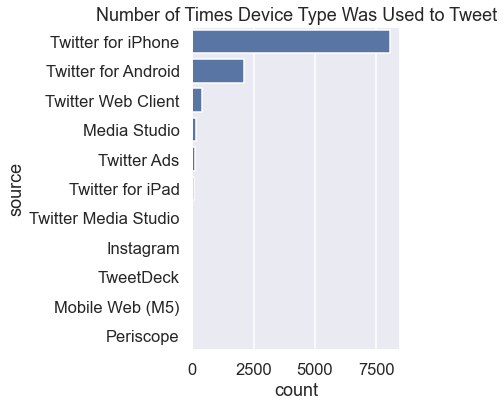

In [20]:
device_counts = df_trump['source'].value_counts()

plt.figure(figsize=(6, 6))
ax = sns.barplot(x=device_counts.values, y=device_counts.index)
plt.xlabel('count')
plt.ylabel('source')
plt.title('Number of Times Device Type Was Used to Tweet')
plt.tight_layout()
plt.show()

### Comparing Trump's Android v Iphone Usage

To compare the time's Trump tweets with android or iphone, first convert times to Eastern time

In [21]:
df_trump['est_time'] = (
    df_trump['time'] 
                 .dt.tz_convert("EST") # Convert to Eastern Time
)
df_trump.head()

,time,source,text,retweet_count,favorite_count,est_time
id,,,,,,
682723973449289728,2016-01-01 00:44:14+00:00,Twitter for Android,"I will be on @FoxNews live, with members of my family, at 11:50 P.M. We will ring in the New Year together! MAKE AMERICA GREAT AGAIN!",2108,6735,2015-12-31 19:44:14-05:00
682764544402440192,2016-01-01 03:25:27+00:00,Twitter for iPhone,HAPPY NEW YEAR &amp; THANK YOU! https://t.co/YO1Yi8QbZy https://t.co/uxUXWJ1Rbv,3460,8581,2015-12-31 22:25:27-05:00
682792967736848385,2016-01-01 05:18:23+00:00,Twitter for iPhone,#HappyNewYearAmerica! https://t.co/EeQb8PDrUe,3434,9143,2016-01-01 00:18:23-05:00
682805320217980929,2016-01-01 06:07:28+00:00,Twitter for iPhone,Happy New Year from #MarALago! Thank you to my great family for all of their support. https://t.co/6UsqSiaaj7,1948,8258,2016-01-01 01:07:28-05:00
682805477168779264,2016-01-01 06:08:06+00:00,Twitter for Android,"""@jallenaip: Hillary said she was in a ""Fog of War"" as explanation for the lies about Benghazi. No fog allowed in WH. Vote Trump POTUS!""",2721,7490,2016-01-01 01:08:06-05:00


Create an 'hour' column representing the precise hour of the day as a floating point, 'roundhour' will be the rounded time

In [22]:
df_trump['hour'] = df_trump['est_time'].dt.hour + df_trump['est_time'].dt.minute / 60 + df_trump['est_time'].dt.second / 3600
df_trump['roundhour']=round(df_trump['hour'])
df_trump

,time,source,text,retweet_count,favorite_count,est_time,hour,roundhour
id,,,,,,,,
682723973449289728,2016-01-01 00:44:14+00:00,Twitter for Android,"I will be on @FoxNews live, with members of my family, at 11:50 P.M. We will ring in the New Year together! MAKE AMERICA GREAT AGAIN!",2108,6735,2015-12-31 19:44:14-05:00,19.737222,20.0
682764544402440192,2016-01-01 03:25:27+00:00,Twitter for iPhone,HAPPY NEW YEAR &amp; THANK YOU! https://t.co/YO1Yi8QbZy https://t.co/uxUXWJ1Rbv,3460,8581,2015-12-31 22:25:27-05:00,22.424167,22.0
682792967736848385,2016-01-01 05:18:23+00:00,Twitter for iPhone,#HappyNewYearAmerica! https://t.co/EeQb8PDrUe,3434,9143,2016-01-01 00:18:23-05:00,0.306389,0.0
682805320217980929,2016-01-01 06:07:28+00:00,Twitter for iPhone,Happy New Year from #MarALago! Thank you to my great family for all of their support. https://t.co/6UsqSiaaj7,1948,8258,2016-01-01 01:07:28-05:00,1.124444,1.0
682805477168779264,2016-01-01 06:08:06+00:00,Twitter for Android,"""@jallenaip: Hillary said she was in a ""Fog of War"" as explanation for the lies about Benghazi. No fog allowed in WH. Vote Trump POTUS!""",2721,7490,2016-01-01 01:08:06-05:00,1.135000,1.0
...,...,...,...,...,...,...,...,...
1101856883634302976,2019-03-02 14:48:47+00:00,Twitter for iPhone,RT @realDonaldTrump: Since my election as President the Dow Jones is up 43% and the NASDAQ Composite almost 50%. Great news for your 401(k)…,24511,0,2019-03-02 09:48:47-05:00,9.813056,10.0
1101857408001949696,2019-03-02 14:50:52+00:00,Twitter for iPhone,RT @realDonaldTrump: I hope our great Republican Senators don’t get led down the path of weak and ineffective Border Security. Without stro…,27707,0,2019-03-02 09:50:52-05:00,9.847778,10.0
1101857665037287425,2019-03-02 14:51:53+00:00,Twitter for iPhone,RT @realDonaldTrump: 93% Approval Rating in the Republican Party. 52% Approval Rating overall! Not bad considering I get the most unfair (B…,34498,0,2019-03-02 09:51:53-05:00,9.864722,10.0


### Plot The Total Number of Tweets At Every Hour Of The Day

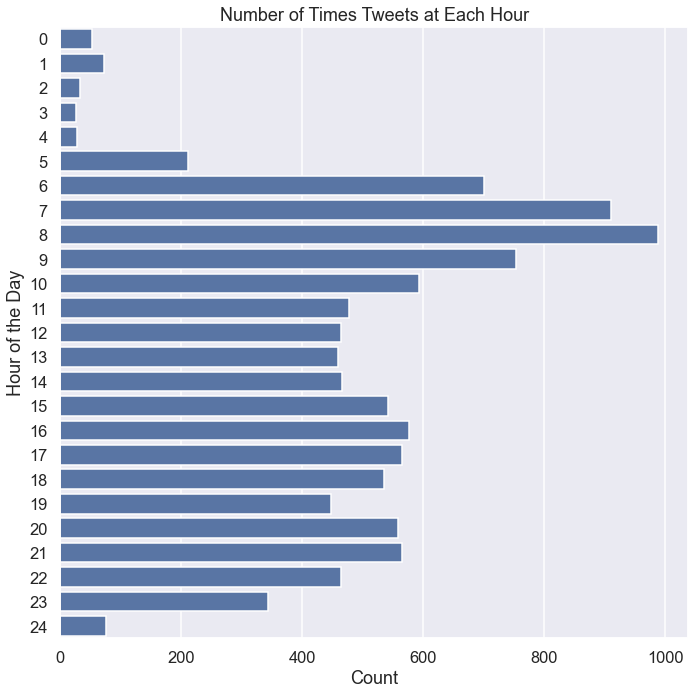

In [23]:
df_trump['roundhour'] = df_trump['hour'].round().astype(int)
plt.figure(figsize=(10, 10))
sns.countplot(data=df_trump, y='roundhour')
plt.ylabel('Hour of the Day')
plt.xlabel('Count')
plt.title('Number of Times Tweets at Each Hour')
plt.tight_layout()
plt.show()

### Plot the distribution over hours of the day that trump tweets for both Android and Iphone 

/var/folders/vm/x0sptm6s3cg2mbp906rr4frc0000gn/T/ipykernel_86307/302987762.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(iphone_tweets['hour'], label='iPhone',color='blue',kde=True,hist=False)
/var/folders/vm/x0sptm6s3cg2mbp906rr4frc0000gn/T/ipykernel_86307/302987762.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom

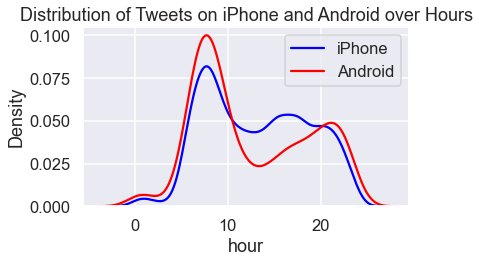

In [24]:
iphone_tweets = df_trump[df_trump['source'] == 'Twitter for iPhone']
android_tweets = df_trump[df_trump['source'] == 'Twitter for Android']

iphone_total = len(iphone_tweets)
android_total = len(android_tweets)

# Combine into 1 single DataFrame for later use
combined_tweets = pd.concat([android_tweets.assign(device='Android'),iphone_tweets.assign(device='iPhone')])

# distplot iPhone
sns.distplot(iphone_tweets['hour'], label='iPhone',color='blue',kde=True,hist=False) 
sns.distplot(android_tweets['hour'],label='Android', color='red',kde=True,hist=False)

plt.legend()
plt.title('Distribution of Tweets on iPhone and Android over Hours')
plt.tight_layout()
plt.show()


### Plot the distribution over hours of the day during Trump's 2016 Campaign

It's speculated that during Trump's campaign, tweets from an android were personally written himself, and tweets from an iphone were written by his staff. Differing time distributions between both devices may support this theory.

/var/folders/vm/x0sptm6s3cg2mbp906rr4frc0000gn/T/ipykernel_86307/764743263.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(android_2016, color='red',label='Android',kde=True,hist=False)
/var/folders/vm/x0sptm6s3cg2mbp906rr4frc0000gn/T/ipykernel_86307/764743263.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147e

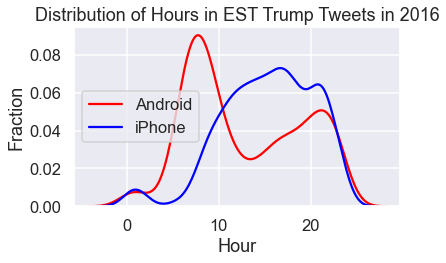

In [25]:
iphone_tweets = df_trump[df_trump['source'] == 'Twitter for iPhone']
android_tweets = df_trump[df_trump['source'] == 'Twitter for Android']

# Combine tweets
combined_tweets = pd.concat([
    iphone_tweets.assign(device='iPhone'),
    android_tweets.assign(device='Android')
])

#2016 only
combined_tweets_2016 = combined_tweets[combined_tweets['time'].dt.year == 2016]
iphone_2016 = combined_tweets_2016[combined_tweets_2016['device'] == 'iPhone']['hour']
android_2016 = combined_tweets_2016[combined_tweets_2016['device'] == 'Android']['hour']

#android plot
sns.distplot(android_2016, color='red',label='Android',kde=True,hist=False)
#iphone plot
sns.distplot(iphone_2016,color='blue',label='iPhone',kde=True,hist=False)


plt.title('Distribution of Hours in EST Trump Tweets in 2016')
plt.xlabel('Hour')
plt.ylabel('Fraction')
plt.legend()
plt.tight_layout()
plt.show()


### Examine Trump's device usage across the years in the entire dataset

First, create 'year' column representing the year as a floating point

In [26]:
from datetime import datetime as dt
import time

def toYearFraction(date):
    if date.tzinfo is not None:
        date = date.tz_localize(None)
    def sinceEpoch(date): 
        return time.mktime(date.timetuple())
    s = sinceEpoch
    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction
    
df_trump['year'] = df_trump['time'].apply(toYearFraction)
df_trump



,time,source,text,retweet_count,favorite_count,est_time,hour,roundhour,year
id,,,,,,,,,
682723973449289728,2016-01-01 00:44:14+00:00,Twitter for Android,"I will be on @FoxNews live, with members of my family, at 11:50 P.M. We will ring in the New Year together! MAKE AMERICA GREAT AGAIN!",2108,6735,2015-12-31 19:44:14-05:00,19.737222,20,2016.000084
682764544402440192,2016-01-01 03:25:27+00:00,Twitter for iPhone,HAPPY NEW YEAR &amp; THANK YOU! https://t.co/YO1Yi8QbZy https://t.co/uxUXWJ1Rbv,3460,8581,2015-12-31 22:25:27-05:00,22.424167,22,2016.000390
682792967736848385,2016-01-01 05:18:23+00:00,Twitter for iPhone,#HappyNewYearAmerica! https://t.co/EeQb8PDrUe,3434,9143,2016-01-01 00:18:23-05:00,0.306389,0,2016.000604
682805320217980929,2016-01-01 06:07:28+00:00,Twitter for iPhone,Happy New Year from #MarALago! Thank you to my great family for all of their support. https://t.co/6UsqSiaaj7,1948,8258,2016-01-01 01:07:28-05:00,1.124444,1,2016.000697
682805477168779264,2016-01-01 06:08:06+00:00,Twitter for Android,"""@jallenaip: Hillary said she was in a ""Fog of War"" as explanation for the lies about Benghazi. No fog allowed in WH. Vote Trump POTUS!""",2721,7490,2016-01-01 01:08:06-05:00,1.135000,1,2016.000698
...,...,...,...,...,...,...,...,...,...
1101856883634302976,2019-03-02 14:48:47+00:00,Twitter for iPhone,RT @realDonaldTrump: Since my election as President the Dow Jones is up 43% and the NASDAQ Composite almost 50%. Great news for your 401(k)…,24511,0,2019-03-02 09:48:47-05:00,9.813056,10,2019.166075
1101857408001949696,2019-03-02 14:50:52+00:00,Twitter for iPhone,RT @realDonaldTrump: I hope our great Republican Senators don’t get led down the path of weak and ineffective Border Security. Without stro…,27707,0,2019-03-02 09:50:52-05:00,9.847778,10,2019.166079
1101857665037287425,2019-03-02 14:51:53+00:00,Twitter for iPhone,RT @realDonaldTrump: 93% Approval Rating in the Republican Party. 52% Approval Rating overall! Not bad considering I get the most unfair (B…,34498,0,2019-03-02 09:51:53-05:00,9.864722,10,2019.166080


### Plot the distribution of Trump's Android vs Iphone usage across the years

/var/folders/vm/x0sptm6s3cg2mbp906rr4frc0000gn/T/ipykernel_86307/3510282134.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/var/folders/vm/x0sptm6s3cg2mbp906rr4frc0000gn/T/ipykernel_86307/3510282134.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


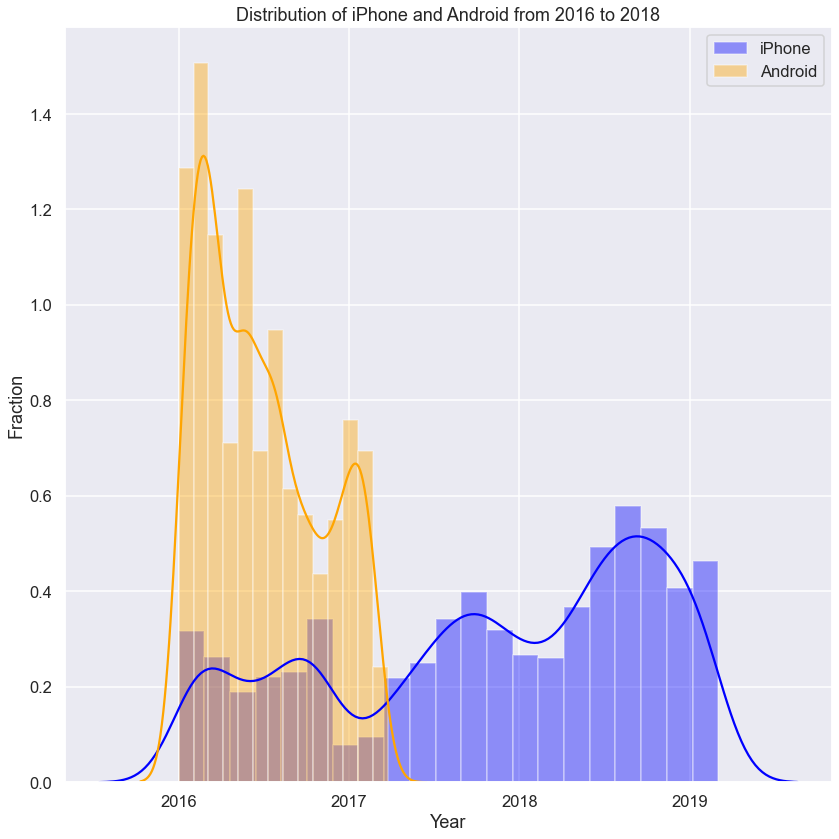

In [27]:
plt.figure(figsize=(12, 12))

# distplot iPhone
sns.distplot(
    df_trump[df_trump['source'] == 'Twitter for iPhone']['year'],
    color='blue',
    label='iPhone',
    hist=True,
    kde=True,
)

# distplot Android
sns.distplot(
    df_trump[df_trump['source'] == 'Twitter for Android']['year'],
    color='orange',
    label='Android',
    hist=True,
    kde=True,
)

plt.title('Distribution of iPhone and Android from 2016 to 2018')
plt.xlabel('Year')
plt.ylabel('Fraction')

plt.legend()
plt.tight_layout()
plt.show()


## SENTIMENT ANALYSIS: Analyzing the positive or negative sentiment of Trump's Tweets

The VADER lexicon gives the sentiment of individual words and emojis

In [28]:
print(''.join(open("vader_lexicon.txt").readlines()[:10]))

$:	-1.5	0.80623	[-1, -1, -1, -1, -3, -1, -3, -1, -2, -1]
%)	-0.4	1.0198	[-1, 0, -1, 0, 0, -2, -1, 2, -1, 0]
%-)	-1.5	1.43178	[-2, 0, -2, -2, -1, 2, -2, -3, -2, -3]
&-:	-0.4	1.42829	[-3, -1, 0, 0, -1, -1, -1, 2, -1, 2]
&:	-0.7	0.64031	[0, -1, -1, -1, 1, -1, -1, -1, -1, -1]
( '}{' )	1.6	0.66332	[1, 2, 2, 1, 1, 2, 2, 1, 3, 1]
(%	-0.9	0.9434	[0, 0, 1, -1, -1, -1, -2, -2, -1, -2]
('-:	2.2	1.16619	[4, 1, 4, 3, 1, 2, 3, 1, 2, 1]
(':	2.3	0.9	[1, 3, 3, 2, 2, 4, 2, 3, 1, 2]
((-:	2.1	0.53852	[2, 2, 2, 1, 2, 3, 2, 2, 3, 2]



### Calculate the sentiment of Trump's tweets

Done by summing the sentiment of each word in the tweet, where a word with positive sentiment has a positive score, and a word with a negative sentiment has a negative score. These sentiment scores are reffered to as polarity.

In [29]:
#read file
vader = open("vader_lexicon.txt").readlines()

#create dictionary to hold the tokens and sentiments
sentiments = {}

#add all tokens and sentiments
for i in vader:
    token = i.split("\t")[0]
    polarity = float(i.split("\t")[1])
    
    sentiments[token] = polarity

#creating df_sent to be used on 3.4
df_sent = pd.DataFrame.from_dict(sentiments, orient = 'index', columns = ['polarity'])

df_trump['text'] = df_trump['text'].str.lower()

#dictionaty to hold all of trumps tweets and their sentiments, which will be converted to a dataframe aferwards
#note: tweets with duplicate text will have the same sentiment, and thus will be combined into one (text,sentiment) value in the dictionary
trumpSents = {}
for index,row in df_trump.iterrows():
    sent = 0
    for word in row["text"].split(" "):
        #if the word exists in the sentiments, add its sentiment, otherwise we cant add it so ignore that case
        if word in sentiments:
            sent+=sentiments[word]
    trumpSents[row["text"]] = sent

trumpSentiments = pd.DataFrame.from_dict(trumpSents, orient = 'index', columns = ['polarity'])

trumpSentiments

,polarity
"i will be on @foxnews live, with members of my family, at 11:50 p.m. we will ring in the new year together! make america great again!",3.1
happy new year &amp; thank you! https://t.co/yo1yi8qbzy https://t.co/uxuxwj1rbv,4.2
#happynewyearamerica! https://t.co/eeqb8pdrue,0.0
happy new year from #maralago! thank you to my great family for all of their support. https://t.co/6usqsiaaj7,7.3
"""@jallenaip: hillary said she was in a ""fog of war"" as explanation for the lies about benghazi. no fog allowed in wh. vote trump potus!""",-3.0
...,...
rt @realdonaldtrump: since my election as president the dow jones is up 43% and the nasdaq composite almost 50%. great news for your 401(k)…,3.1
rt @realdonaldtrump: i hope our great republican senators don’t get led down the path of weak and ineffective border security. without stro…,2.6
rt @realdonaldtrump: 93% approval rating in the republican party. 52% approval rating overall! not bad considering i get the most unfair (b…,-0.4
"@teamcavuto it was a 3 day train ride to vietnam, not 3 hours!",0.0


### Remove punctuation for more accurate polarity assessments


In [30]:
import re
# Save regex in punct_re
punct_re = r'[^\w\s\\n]'

#replace punctuation marks with a space
def no_punc(txt):
    return re.sub(r'[^\w\s]', ' ', txt)

df_trump['no_punc'] = df_trump['text'].apply(no_punc)

df_trump

###


,time,source,text,retweet_count,favorite_count,est_time,hour,roundhour,year,no_punc
id,,,,,,,,,,
682723973449289728,2016-01-01 00:44:14+00:00,Twitter for Android,"i will be on @foxnews live, with members of my family, at 11:50 p.m. we will ring in the new year together! make america great again!",2108,6735,2015-12-31 19:44:14-05:00,19.737222,20,2016.000084,i will be on foxnews live with members of my family at 11 50 p m we will ring in the new year together make america great again
682764544402440192,2016-01-01 03:25:27+00:00,Twitter for iPhone,happy new year &amp; thank you! https://t.co/yo1yi8qbzy https://t.co/uxuxwj1rbv,3460,8581,2015-12-31 22:25:27-05:00,22.424167,22,2016.000390,happy new year amp thank you https t co yo1yi8qbzy https t co uxuxwj1rbv
682792967736848385,2016-01-01 05:18:23+00:00,Twitter for iPhone,#happynewyearamerica! https://t.co/eeqb8pdrue,3434,9143,2016-01-01 00:18:23-05:00,0.306389,0,2016.000604,happynewyearamerica https t co eeqb8pdrue
682805320217980929,2016-01-01 06:07:28+00:00,Twitter for iPhone,happy new year from #maralago! thank you to my great family for all of their support. https://t.co/6usqsiaaj7,1948,8258,2016-01-01 01:07:28-05:00,1.124444,1,2016.000697,happy new year from maralago thank you to my great family for all of their support https t co 6usqsiaaj7
682805477168779264,2016-01-01 06:08:06+00:00,Twitter for Android,"""@jallenaip: hillary said she was in a ""fog of war"" as explanation for the lies about benghazi. no fog allowed in wh. vote trump potus!""",2721,7490,2016-01-01 01:08:06-05:00,1.135000,1,2016.000698,jallenaip hillary said she was in a fog of war as explanation for the lies about benghazi no fog allowed in wh vote trump potus
...,...,...,...,...,...,...,...,...,...,...
1101856883634302976,2019-03-02 14:48:47+00:00,Twitter for iPhone,rt @realdonaldtrump: since my election as president the dow jones is up 43% and the nasdaq composite almost 50%. great news for your 401(k)…,24511,0,2019-03-02 09:48:47-05:00,9.813056,10,2019.166075,rt realdonaldtrump since my election as president the dow jones is up 43 and the nasdaq composite almost 50 great news for your 401 k
1101857408001949696,2019-03-02 14:50:52+00:00,Twitter for iPhone,rt @realdonaldtrump: i hope our great republican senators don’t get led down the path of weak and ineffective border security. without stro…,27707,0,2019-03-02 09:50:52-05:00,9.847778,10,2019.166079,rt realdonaldtrump i hope our great republican senators don t get led down the path of weak and ineffective border security without stro
1101857665037287425,2019-03-02 14:51:53+00:00,Twitter for iPhone,rt @realdonaldtrump: 93% approval rating in the republican party. 52% approval rating overall! not bad considering i get the most unfair (b…,34498,0,2019-03-02 09:51:53-05:00,9.864722,10,2019.166080,rt realdonaldtrump 93 approval rating in the republican party 52 approval rating overall not bad considering i get the most unfair b


### Test Asserts

In [31]:
assert isinstance(punct_re, str)
assert re.search(punct_re, 'this') is None
assert re.search(punct_re, 'this is ok') is None
assert re.search(punct_re, 'this is\nok') is None
assert re.search(punct_re, 'this is not ok.') is not None
assert re.search(punct_re, 'this#is#ok') is not None
assert re.search(punct_re, 'this^is ok') is not None
assert df_trump['no_punc'].loc[800329364986626048] == 'i watched parts of  nbcsnl saturday night live last night  it is a totally one sided  biased show   nothing funny at all  equal time for us '
assert df_trump['text'].loc[884740553040175104] == 'working hard to get the olympics for the united states (l.a.). stay tuned!'


### Alternate Strategy: Create a new table called 'tidy_format', which separates each word of a tweet into rows displayed in order and identified by their tweet id

In [32]:
tidy_format = df_trump['no_punc'].str.split(expand=True).stack().reset_index(level=1).rename(columns = {'level_1': 'num', 0:'word'})
tidy_format 

,num,word
id,,
682723973449289728,0,i
682723973449289728,1,will
682723973449289728,2,be
682723973449289728,3,on
682723973449289728,4,foxnews
...,...,...
1101880269106221058,2,marklevinshow
1101880269106221058,3,https
1101880269106221058,4,t


In [33]:
assert tidy_format.loc[894661651760377856].shape == (27, 2)
assert ' '.join(list(tidy_format.loc[894661651760377856]['word'])) == 'i think senator blumenthal should take a nice long vacation in vietnam where he lied about his service so he can at least say he was there'

### Find the polarities of each tweet using tidy_format

Done by merging the sentiment dictionary df_sent with tidy_format, summing the polarities of each word in the tweet, and adding the value into the new polarity column in df_trump

In [34]:
#merge original token-sentiment table with tidy format table to get each word and its individual polarity
#any words that are not in the vader lexicon will be set to zero
indivPolarities = tidy_format.merge(df_sent, left_on='word', right_index=True, how='left').fillna(0)
                     
    
#sum the sentiments of the grouped tweet ID's
tweetSentiments = indivPolarities.groupby(level=0)['polarity'].sum()
                      
#create the polarity column in df_trump with the summed sentiments
df_trump['polarity'] = tweetSentiments

### 
df_trump

,time,source,text,retweet_count,favorite_count,est_time,hour,roundhour,year,no_punc,polarity
id,,,,,,,,,,,
682723973449289728,2016-01-01 00:44:14+00:00,Twitter for Android,"i will be on @foxnews live, with members of my family, at 11:50 p.m. we will ring in the new year together! make america great again!",2108,6735,2015-12-31 19:44:14-05:00,19.737222,20,2016.000084,i will be on foxnews live with members of my family at 11 50 p m we will ring in the new year together make america great again,3.1
682764544402440192,2016-01-01 03:25:27+00:00,Twitter for iPhone,happy new year &amp; thank you! https://t.co/yo1yi8qbzy https://t.co/uxuxwj1rbv,3460,8581,2015-12-31 22:25:27-05:00,22.424167,22,2016.000390,happy new year amp thank you https t co yo1yi8qbzy https t co uxuxwj1rbv,4.2
682792967736848385,2016-01-01 05:18:23+00:00,Twitter for iPhone,#happynewyearamerica! https://t.co/eeqb8pdrue,3434,9143,2016-01-01 00:18:23-05:00,0.306389,0,2016.000604,happynewyearamerica https t co eeqb8pdrue,0.0
682805320217980929,2016-01-01 06:07:28+00:00,Twitter for iPhone,happy new year from #maralago! thank you to my great family for all of their support. https://t.co/6usqsiaaj7,1948,8258,2016-01-01 01:07:28-05:00,1.124444,1,2016.000697,happy new year from maralago thank you to my great family for all of their support https t co 6usqsiaaj7,9.0
682805477168779264,2016-01-01 06:08:06+00:00,Twitter for Android,"""@jallenaip: hillary said she was in a ""fog of war"" as explanation for the lies about benghazi. no fog allowed in wh. vote trump potus!""",2721,7490,2016-01-01 01:08:06-05:00,1.135000,1,2016.000698,jallenaip hillary said she was in a fog of war as explanation for the lies about benghazi no fog allowed in wh vote trump potus,-5.9
...,...,...,...,...,...,...,...,...,...,...,...
1101856883634302976,2019-03-02 14:48:47+00:00,Twitter for iPhone,rt @realdonaldtrump: since my election as president the dow jones is up 43% and the nasdaq composite almost 50%. great news for your 401(k)…,24511,0,2019-03-02 09:48:47-05:00,9.813056,10,2019.166075,rt realdonaldtrump since my election as president the dow jones is up 43 and the nasdaq composite almost 50 great news for your 401 k,3.1
1101857408001949696,2019-03-02 14:50:52+00:00,Twitter for iPhone,rt @realdonaldtrump: i hope our great republican senators don’t get led down the path of weak and ineffective border security. without stro…,27707,0,2019-03-02 09:50:52-05:00,9.847778,10,2019.166079,rt realdonaldtrump i hope our great republican senators don t get led down the path of weak and ineffective border security without stro,4.0
1101857665037287425,2019-03-02 14:51:53+00:00,Twitter for iPhone,rt @realdonaldtrump: 93% approval rating in the republican party. 52% approval rating overall! not bad considering i get the most unfair (b…,34498,0,2019-03-02 09:51:53-05:00,9.864722,10,2019.166080,rt realdonaldtrump 93 approval rating in the republican party 52 approval rating overall not bad considering i get the most unfair b,1.3


In [35]:
assert np.allclose(df_trump.loc[744701872456536064, 'polarity'], 8.4)
assert np.allclose(df_trump.loc[745304731346702336, 'polarity'], 2.5)
assert np.allclose(df_trump.loc[744519497764184064, 'polarity'], 1.7)
assert np.allclose(df_trump.loc[894661651760377856, 'polarity'], 0.2)
assert np.allclose(df_trump.loc[894620077634592769, 'polarity'], 5.4)
assert np.allclose(df_trump.loc[744355251365511169, 'polarity'], 0.0)


### Display Trump's 20 most positive and negative tweets

In [36]:
print('Most negative tweets:')

sorted_df = df_trump.sort_values('polarity', ascending=True)

sorted_df.head(20)

Most negative tweets:


,time,source,text,retweet_count,favorite_count,est_time,hour,roundhour,year,no_punc,polarity
id,,,,,,,,,,,
1084649448003784704,2019-01-14 03:12:34+00:00,Twitter for iPhone,"the trump portrait of an unsustainable border crisis is dead on. “in the last two years, ice officers made 266,000 arrests of aliens with criminal records, including those charged or convicted of 100,000 assaults, 30,000 sex crimes &amp; 4000 violent killings.” america’s sout...",21493,81040,2019-01-13 22:12:34-05:00,22.209444,22,2019.035983,the trump portrait of an unsustainable border crisis is dead on in the last two years ice officers made 266 000 arrests of aliens with criminal records including those charged or convicted of 100 000 assaults 30 000 sex crimes amp 4000 violent killings america s sout...,-20.4
1031590431379865600,2018-08-20 17:14:59+00:00,Twitter for iPhone,"it is outrageous that poisonous synthetic heroin fentanyl comes pouring into the u.s. postal system from china. we can, and must, end this now! the senate should pass the stop act – and firmly stop this poison from killing our children and destroying our country. no more delay!",28007,103194,2018-08-20 12:14:59-05:00,12.249722,12,2018.634732,it is outrageous that poisonous synthetic heroin fentanyl comes pouring into the u s postal system from china we can and must end this now the senate should pass the stop act and firmly stop this poison from killing our children and destroying our country no more delay,-20.3
1029731513573822464,2018-08-15 14:08:18+00:00,Twitter for iPhone,"the rigged russian witch hunt goes on and on as the “originators and founders” of this scam continue to be fired and demoted for their corrupt and illegal activity. all credibility is gone from this terrible hoax, and much more will be lost as it proceeds. no collusion!",18887,77843,2018-08-15 09:08:18-05:00,9.138333,9,2018.620678,the rigged russian witch hunt goes on and on as the originators and founders of this scam continue to be fired and demoted for their corrupt and illegal activity all credibility is gone from this terrible hoax and much more will be lost as it proceeds no collusion,-16.6
1056299897882923009,2018-10-27 21:41:35+00:00,Twitter for iPhone,...this evil anti-semitic attack is an assault on humanity. it will take all of us working together to extract the poison of anti-semitism from our world. we must unite to conquer hate.,20428,85007,2018-10-27 16:41:35-05:00,16.693056,17,2018.821540,this evil anti semitic attack is an assault on humanity it will take all of us working together to extract the poison of anti semitism from our world we must unite to conquer hate,-16.1
984763579210633216,2018-04-13 12:01:47+00:00,Twitter for iPhone,"james comey is a proven leaker &amp; liar. virtually everyone in washington thought he should be fired for the terrible job he did-until he was, in fact, fired. he leaked classified information, for which he should be prosecuted. he lied to congress under oath. he is a weak a...",31488,122649,2018-04-13 07:01:47-05:00,7.029722,7,2018.280711,james comey is a proven leaker amp liar virtually everyone in washington thought he should be fired for the terrible job he did until he was in fact fired he leaked classified information for which he should be prosecuted he lied to congress under oath he is a weak a...,-16.0
1074319076766433280,2018-12-16 15:03:22+00:00,Twitter for iPhone,"at the request of many, i will be reviewing the case of a “u.s. military hero,” major matt golsteyn, who is charged with murder. he could face the death penalty from our own government after he admitted to killing a terrorist bomb maker while overseas. @petehegseth @foxnews",25633,99484,2018-12-16 10:03:22-05:00,10.056111,10,2018.957883,at the request of many i will be reviewing the case of a u s military hero major matt golsteyn who is charged with murder he could face the death penalty from our own government after he admitted to killing a terrorist bomb maker while overseas petehegseth fox

In [37]:
print('Most positive tweets:')
   
sortedDf = df_trump.sort_values('polarity', ascending=False)

sortedDf.head(20) 

Most positive tweets:


,time,source,text,retweet_count,favorite_count,est_time,hour,roundhour,year,no_punc,polarity
id,,,,,,,,,,,
983143317889323008,2018-04-09 00:43:27+00:00,Twitter for iPhone,"congratulations to patrick reed on his great and courageous masters win! when patrick had his amazing win at doral 5 years ago, people saw his great talent, and a bright future ahead. now he is the masters champion!",12169,89538,2018-04-08 19:43:27-05:00,19.724167,20,2018.268462,congratulations to patrick reed on his great and courageous masters win when patrick had his amazing win at doral 5 years ago people saw his great talent and a bright future ahead now he is the masters champion,26.5
1082648785312976896,2019-01-08 14:42:39+00:00,Twitter for iPhone,"congratulations to a truly great football team, the clemson tigers, on an incredible win last night against a powerful alabama team. a big win also for the great state of south carolina. look forward to seeing the team, and their brilliant coach, for the second time at the w.h.",20449,133494,2019-01-08 09:42:39-05:00,9.710833,10,2019.020857,congratulations to a truly great football team the clemson tigers on an incredible win last night against a powerful alabama team a big win also for the great state of south carolina look forward to seeing the team and their brilliant coach for the second time at the w h,21.2
1007974129474121728,2018-06-16 13:12:14+00:00,Twitter for iPhone,"my supporters are the smartest, strongest, most hard working and most loyal that we have seen in our countries history. it is a beautiful thing to watch as we win elections and gather support from all over the country. as we get stronger, so does our country. best numbers ever!",42103,180126,2018-06-16 08:12:14-05:00,8.203889,8,2018.456188,my supporters are the smartest strongest most hard working and most loyal that we have seen in our countries history it is a beautiful thing to watch as we win elections and gather support from all over the country as we get stronger so does our country best numbers ever,20.7
1016638035281219584,2018-07-10 10:59:30+00:00,Twitter for iPhone,"thank you to all of my great supporters, really big progress being made. other countries wanting to fix crazy trade deals. economy is roaring. supreme court pick getting great reviews. new poll says trump, at over 90%, is the most popular republican in history of the party. wow!",25284,122789,2018-07-10 05:59:30-05:00,5.991667,6,2018.521689,thank you to all of my great supporters really big progress being made other countries wanting to fix crazy trade deals economy is roaring supreme court pick getting great reviews new poll says trump at over 90 is the most popular republican in history of the party wow,18.9
1014287566386888709,2018-07-03 23:19:35+00:00,Twitter for iPhone,"thank you, @wvgovernor jim justice, for that warm introduction. tonight, it was my great honor to attend the “greenbrier classic – salute to service dinner” in west virginia! god bless our veterans. god bless america - and happy independence day to all! https://t.co/v35qvcn8m6",9951,48540,2018-07-03 18:19:35-05:00,18.326389,18,2018.503919,thank you wvgovernor jim justice for that warm introduction tonight it was my great honor to attend the greenbrier classic salute to service dinner in west virginia god bless our veterans god bless america and happy independence day to all https t co v35qvcn8m6,18.6
994176238846664706,2018-05-09 11:24:20+00:00,Twitter for iPhone,"the republican party had a great night. tremendous voter energy and excitement, and all candidates are those who have a great chance of winning in november. the economy is sooo strong, and with nancy pelosi wanting to end the big tax cuts and raise taxes, why wouldn’t we win?",18374,80777,2018-05-09 06:24:20-05:00,6.405556,6,2018.351873,the republican party had a great night tremendous voter energy and excitement and all candidates are those who have a great chance of winning in november the economy is sooo strong and with nancy pel

### Plot the distribution of Trump's sentiments when he mentions 'fox' and when he mentions 'nyt'
We can use this to infer which news source he aligns with.

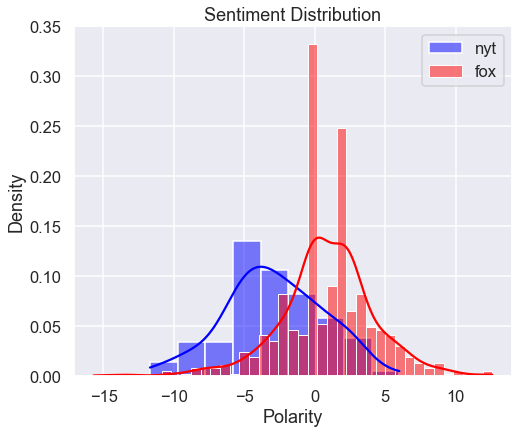

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
# Create the dataframes with case-insensitive filtering
nytTweets = df_trump[['text','polarity']].copy()
nytTweets['hasNyt'] = df_trump['text'].str.contains('@nyt', case=False)
nytTweets = nytTweets[nytTweets['hasNyt']] 
""" 
using '@nyt' gets the majority of cases
To get nearly all cases:
#df_trump[df_trump['text'].str.contains(r'\b(?:nyt|nytimes|new york times|ny times)\b', case=False)]
"""

foxTweets = df_trump[['text','polarity']].copy()
foxTweets['hasFox'] = df_trump['text'].str.contains('fox', case=False)
foxTweets = foxTweets[foxTweets['hasFox']]  


plt.figure(figsize=(7, 6))
sns.histplot(data=nytTweets, x='polarity', stat='density', alpha=0.5, kde=True, label='nyt', color='blue')
sns.histplot(data=foxTweets, x='polarity', stat='density', alpha=0.5, kde=True, label='fox', color='red')


plt.title('Sentiment Distribution')
plt.xlabel('Polarity')
plt.ylabel('Density')
plt.ylim(0, 0.35)
plt.legend()
plt.show()
### 

Overall, Trump clearly has a more positive sentiment towards Fox News than he has towards the New York Times. Though, there are two peak sentiments for Fox news are around 0 and 2.5, which indicates most of his tweets metioning Fox news are either neutral or more positive leaning. For New York Times, the single peak around about -5 indicates that Trump has a negative sentiment towards the New York Times in the majority of his tweets. These results are not surprising since Fox News is considered to be a right leaning media source, which aligns with Trump's views and campaign. The New York Times are considered to be a more left leaning media source, which doesn't align with Trump's views and campaign.

## Principal Component Analysis 
Analyzing Trump’s tweets shows that certain words often appear together, such as the slogan Make America Great Again. Instead of focusing on individual words, grouping them through Principal Component Analysis (PCA) can provide deeper insights.

What is PCA?
PCA is a technique for identifying patterns and reducing the number of variables in a dataset while preserving most of the variance. It selects components with the highest variance, ensuring subsequent components are orthogonal and capture as much remaining variance as possible. Each component is a weighted combination of input variables, with weights (loading factors) indicating the contribution of each variable. Parameters with strong positive or negative loadings reveal trends and correlations within the data.

### Cleaning up the Data
Use NLTK (Natural Language Toolkit) package for language processing, prepare tweet data for analysis by cleaning, standardizing, and reducing the dataset. This code generates a frequency representation of the 50 most common words across Trump's tweets and displays how often each word shows up in each tweet. This enables further analysis such as clustering, classification, and sentiment modeling. (For the next cell: Each row in the outputted array is a tweet, and each number represents a word and if it appears in the tweet)

In [39]:
%pip install nltk
import nltk
import nltk.corpus
from nltk.corpus import stopwords #import nltk list of stopwords (a, i, or, is, the) that don't provide much meaning
from nltk.stem import WordNetLemmatizer #library to convert words into lemmas of their relevant dictionary meaning
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords') #download necessary stopword data
nltk.download('wordnet')
nltk.download('punkt')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/davidr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/davidr/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/davidr/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [40]:
# create a set containing stopwords and political names that will be removed from tidy_format
stopSet = set(stopwords.words('english'))
politicWords = {'realdonaldtrump', 'donald', 'trump'  ,'trump2016', 'http', 'hillary', 'amp','clinton', "un", "disgraceful", "emails", "citizens", "players"}
stopSet.update(politicWords)

#copy tidy_format for modification
lemmaWords = tidy_format.copy()

#create lemmatizer
lem= WordNetLemmatizer()

#simplify the words using the lemmatizer
lemmaWords['word'] = lemmaWords['word'].str.lower().apply(lem.lemmatize)

#remove stopwords
lemmaWords= lemmaWords.loc[~lemmaWords['word'].isin(stopSet)] 

#remove words with length<3
lemmaWords= lemmaWords.loc[lemmaWords['word'].str.len() > 2] 

#remove digits
lemmaWords=lemmaWords.loc[~lemmaWords['word'].str.isdigit()]

# extract the fifty most used words that we will analyze
mostUsedWords = lemmaWords['word'].value_counts().head(50).index.tolist()


#create frequency table each word in the tweet
freq = pd.crosstab(lemmaWords.index, lemmaWords['word'])

#filter out to keep only the top 50 words and the first 5000 tweets
freq = freq[mostUsedWords].iloc[:5000]

#convert to array of floats
df_array = freq.to_numpy()
df_array = df_array.astype(float)
df_array[:10]


array([[1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

### Find the PCA's using Scikit-learn

In [41]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(df_array)
components = pca.components_
components

array([[ 8.15285753e-01,  1.76083783e-01,  3.43009409e-02, ...,
         7.00586309e-03, -6.01781519e-05, -6.63856561e-03],
       [-1.28418037e-01,  9.15602089e-01, -1.21200836e-01, ...,
        -1.43081182e-02, -1.20113359e-02, -2.59464702e-02],
       [ 2.87484041e-01,  1.14115618e-01,  6.89268794e-01, ...,
         8.43907423e-03,  4.18731961e-03,  1.20415907e-02],
       ...,
       [ 2.00971350e-03, -9.31518312e-04,  6.82621339e-03, ...,
         4.80733666e-01,  8.32532250e-01, -3.44170559e-04],
       [ 4.29888102e-03,  2.60848491e-03,  2.98292048e-03, ...,
         1.54387492e-02,  3.31629436e-02, -1.68941317e-02],
       [ 6.66081580e-03,  6.04084421e-03, -1.89929936e-03, ...,
        -1.13091460e-01,  1.17583156e-01,  9.48300859e-03]])

### Examine the PCA as a heat grid plot
The heat grid plot shows the various principal component along the x-axis and the individual words along the y-axes. Each grid box color represents the sign of the loading factor and how large that value is. The loading factor indicates how much a given variable (word) contributes to a particular principal component and helps interpret the relationship between the components and the original variables. Vertically, you can see which words constitute your principal components. Horizontally, you can see how individual terms are shared between components.

<AxesSubplot:>

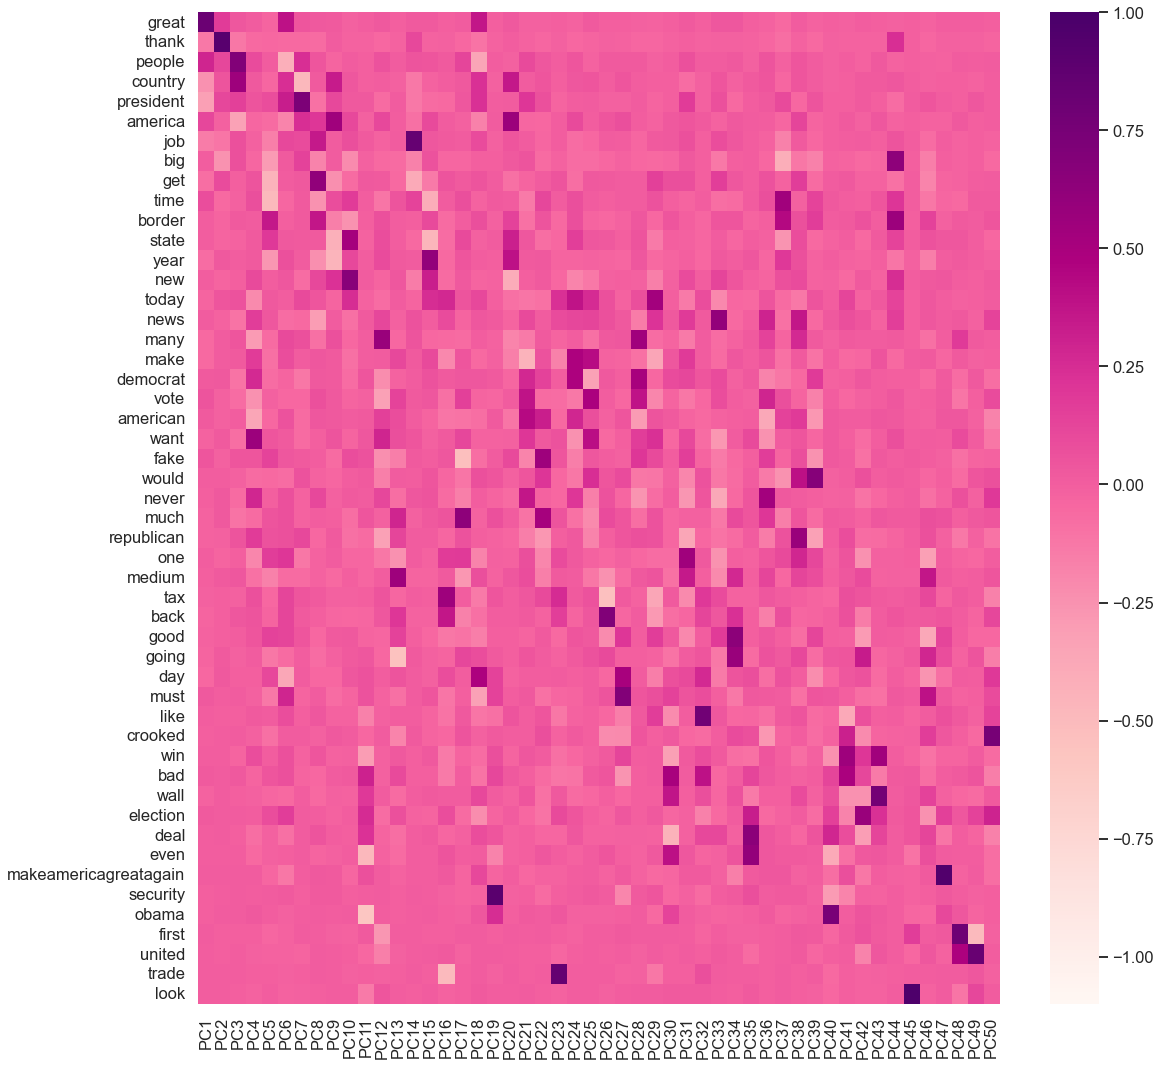

In [42]:
import seaborn as sns
pcDF= pd.DataFrame(components,columns=mostUsedWords)
plt.figure(figsize=(16,17))
sns.heatmap(pcDF, cmap="RdPu", vmin= 1.0, vmax=-1.0, xticklabels=["PC"+str(x) for x in range(1,51)], yticklabels=mostUsedWords)

### Visualize the relationship between the first two principal components PC1 and PC2
Visualizing the contribution of the original variables to the first two principal components can help us understand how the features are distributed and correlated in the transformed PCA space.

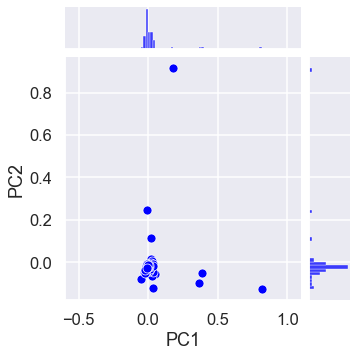

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get first two principal components
prinComp1 = pca.components_[0]
prinComp2 = pca.components_[1]

# Create jointplot
jplot = sns.jointplot(x=prinComp1, y=prinComp2, kind='scatter', height=5, color='blue')

jplot.ax_joint.set_xlabel('PC1')
jplot.ax_joint.set_ylabel('PC2')
jplot.ax_joint.set_xlim(-0.6, 1.1)
plt.show()

## ENGAGEMENT; Examining which words correlated with the most retweets

### Print the top 20 most **retweeted words**. 
Only for words which appear at least 25 times.

In [44]:
def most_retweeted_words(df):
    # Word DataFrame
    words_df = (
        # split and lowercase the words 
        df.assign(word=df['no_punc'].str.lower().str.split()).explode('word').assign(word=lambda x: x['word'].str.extract(r'([a-zA-Z]+)'))
        .loc[lambda x: ~x['word'].isin(stopSet)])

    # Count unique word per tweet
    word_counts = words_df.groupby('word')['no_punc'].nunique()

    return (words_df[words_df['word'].isin(word_counts[word_counts >= 25].index)].groupby('word')['retweet_count'].mean().sort_values(ascending=False).head(20).round(6))

top_20 = most_retweeted_words(df_trump)
print(top_20)

word
jong          33497.955556
maybe         29861.093750
kavanaugh     29274.392857
mccabe        29247.866667
old           28794.926829
kim           28324.633803
illegally     28272.957447
try           27802.000000
human         27716.107143
flag          27522.705882
nuclear       27317.616667
powerful      26457.484848
mainstream    26355.258065
lowest        26264.313725
nfl           25955.621622
necessary     25740.035714
enemy         25512.717949
fbi           25386.150407
forced        25254.538462
longer        25170.906250
Name: retweet_count, dtype: float64


### Plot Top Retweeted Words

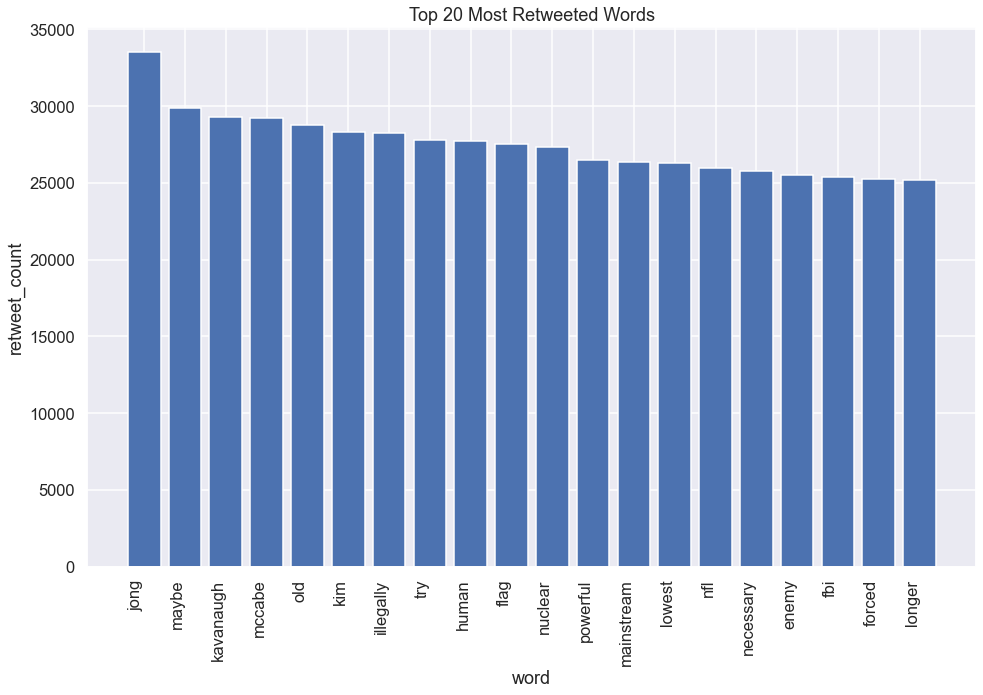

In [45]:
plt.figure(figsize=(14, 10))
# Plot bar
plt.bar(top_20.index, top_20.values)

# name on xy axis
plt.title('Top 20 Most Retweeted Words')
plt.xlabel('word')
plt.ylabel('retweet_count')

# Rotate
plt.xticks(rotation=90, ha='right')

plt.tight_layout()
plt.show()



### Print top 20 most favorited Tweets and their sentiments

In [46]:
def get_top_favorite_tweets(df):
    # top 20
    top_favorites = (
        df.sort_values('favorite_count', ascending=False).head(20))
    
    # sentiment from polarity
    top_favorites['sentiment'] = top_favorites['polarity'].apply(lambda x: 'Positive' if x > 0 else 'Negative')
    
    # Select required columns and index id
    result = top_favorites[['text', 'sentiment']]
    result = result.reset_index()  
    
    # Reorder columns
    result = result[['id', 'text', 'sentiment']]

    favorite_df = pd.DataFrame(result)
    return favorite_df

top_favorites = get_top_favorite_tweets(df_trump)
top_favorites


,id,text,sentiment
0,796315640307060738,such a beautiful and important evening! the forgotten man and woman will never be forgotten again. we will all come together as never before,Positive
1,881503147168071680,#fraudnewscnn #fnn https://t.co/wyunhjjujg,Negative
2,929511061954297857,"why would kim jong-un insult me by calling me ""old,"" when i would never call him ""short and fat?"" oh well, i try so hard to be his friend - and maybe someday that will happen!",Positive
3,795954831718498305,today we make america great again!,Positive
4,1077549301449060352,merry christmas!,Positive
5,948355557022420992,"north korean leader kim jong un just stated that the “nuclear button is on his desk at all times.” will someone from his depleted and food starved regime please inform him that i too have a nuclear button, but it is a much bigger &amp; more powerful one than his, and my butto...",Positive
6,823174199036542980,"peaceful protests are a hallmark of our democracy. even if i don't always agree, i recognize the rights of people to express their views.",Positive
7,989225812166696960,"thank you kanye, very cool! https://t.co/vric87m21x",Positive
8,815185071317676033,"happy new year to all, including to my many enemies and those who have fought me and lost so badly they just don't know what to do. love!",Negative
9,1056885392522260480,"had a very good conversation with the newly elected president of brazil, jair bolsonaro, who won his race by a substantial margin. we agreed that brazil and the united states will work closely together on trade, military and everything else! excellent call, wished him congrats!",Positive


### Plot total sentiments between positive and negative tweets

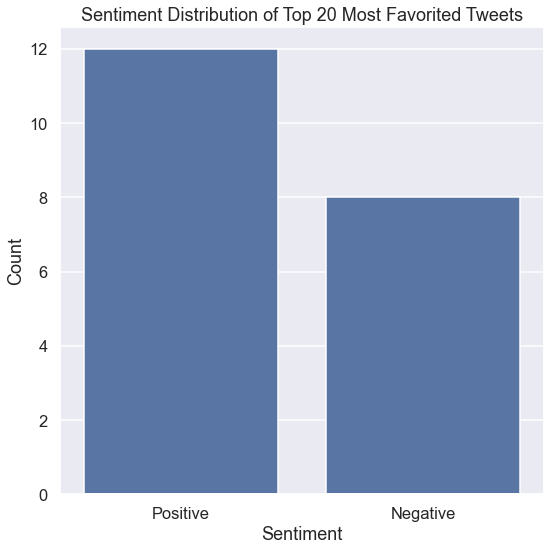

In [47]:
plt.figure(figsize=(8,8))
sentiment_pos = top_favorites['sentiment'].value_counts()
# Plot bar
sns.barplot(x=sentiment_pos.index,y=sentiment_pos.values)
# name on xy axis
plt.title('Sentiment Distribution of Top 20 Most Favorited Tweets')
plt.xlabel('Sentiment')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

